In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import supervision as sv

from roboflow import login,Roboflow

# login()
# rf = Roboflow()
# project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
# dataset = project.version(5).download("coco-segmentation")

rf = Roboflow(api_key="")
project = rf.workspace("segmentation-yolov5").project("yolov5_seg-tm3yy")
dataset = project.version(10).download("coco-segmentation")

train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)

from autodistill_seggpt.dataset_utils import extract_classes_from_dataset
print(train_dataset.classes)
# train_dataset = extract_classes_from_dataset(train_dataset, [1])


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Yolov5_seg-10 in coco-segmentation:: 100%|██████████| 1791/1791 [00:00<00:00, 3369.20it/s]
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


['screw', 'Horizontal', 'Vertical']


In [3]:
pred_datasets = []

from random import choice
from PIL import Image
import cv2
from autodistill_seggpt.dataset_utils import label_dataset

valid_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
    force_masks=True
)

In [4]:
def show_img(dataset: sv.DetectionDataset, name=None):

    if name is None:
        name = choice(list(dataset.images.keys()))
    if type(name) == int:
        name = sorted(list(dataset.images.keys()))[name]

    detections = dataset.annotations[name]
    img = dataset.images[name]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotator = sv.MaskAnnotator()

    annotated_frame = annotator.annotate(
        scene=img,
        detections=detections
    )

    return Image.fromarray(annotated_frame)

In [5]:
# from autodistill_seggpt.find_best_examples import find_best_ensembles, imgset_entries
from autodistill_seggpt.few_shot_ontology import default_model

from autodistill_seggpt import sample_ontology, grow_ontology

from autodistill_seggpt.metrics import metrics_registry

from autodistill_seggpt import SegGPT

metric="map"
metric = metrics_registry[metric]

# ontology = sample_ontology(
#     ref_dataset=train_dataset,
#     make_model=default_model,
#     metric=metric,

#     num_examples=2,
#     num_trials=10
# )

ontology = grow_ontology(
    ref_dataset=train_dataset,
    make_model=default_model,
    metric=metric,

    num_examples=4,
    num_trials=5
)

base_model = SegGPT(
    ontology,
    refine_detections=True,
)

AttributeError: type object 'DatasetMetric' has no attribute 'validate_datasets'

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [01:38<00:00,  6.15s/it]


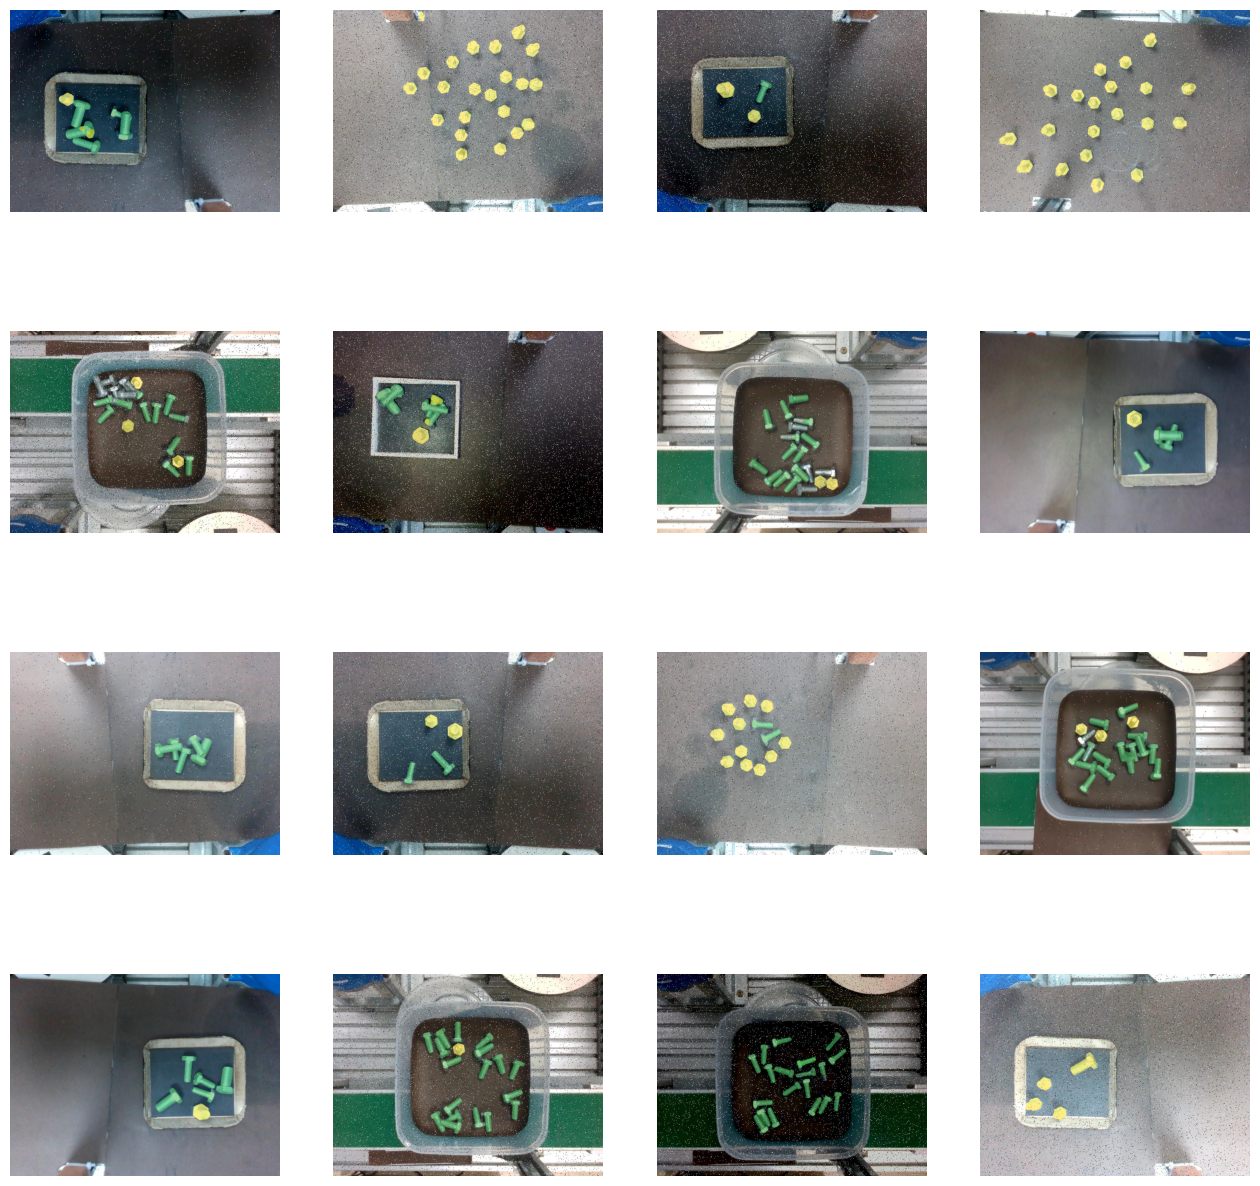

<Figure size 640x480 with 0 Axes>

In [ ]:
from autodistill_seggpt.seggpt import SegGPT
from autodistill_seggpt.few_shot_ontology import FewShotOntologySimple
import autodistill_seggpt.postprocessing
from autodistill_seggpt.dataset_utils import extract_images_from_dataset,viz_dataset
from random import sample

annotator = sv.MaskAnnotator()

from autodistill_seggpt.dataset_utils import label_dataset

mini_train_dataset = extract_images_from_dataset(train_dataset,sample(list(train_dataset.images.keys()),16))

pred_dataset = label_dataset(mini_train_dataset,base_model,use_tqdm=True)

viz_dataset("climbing-pred.png",pred_dataset)

In [ ]:
metric.evaluate_datasets(train_dataset, pred_dataset).tolist()

NameError: name 'metric' is not defined

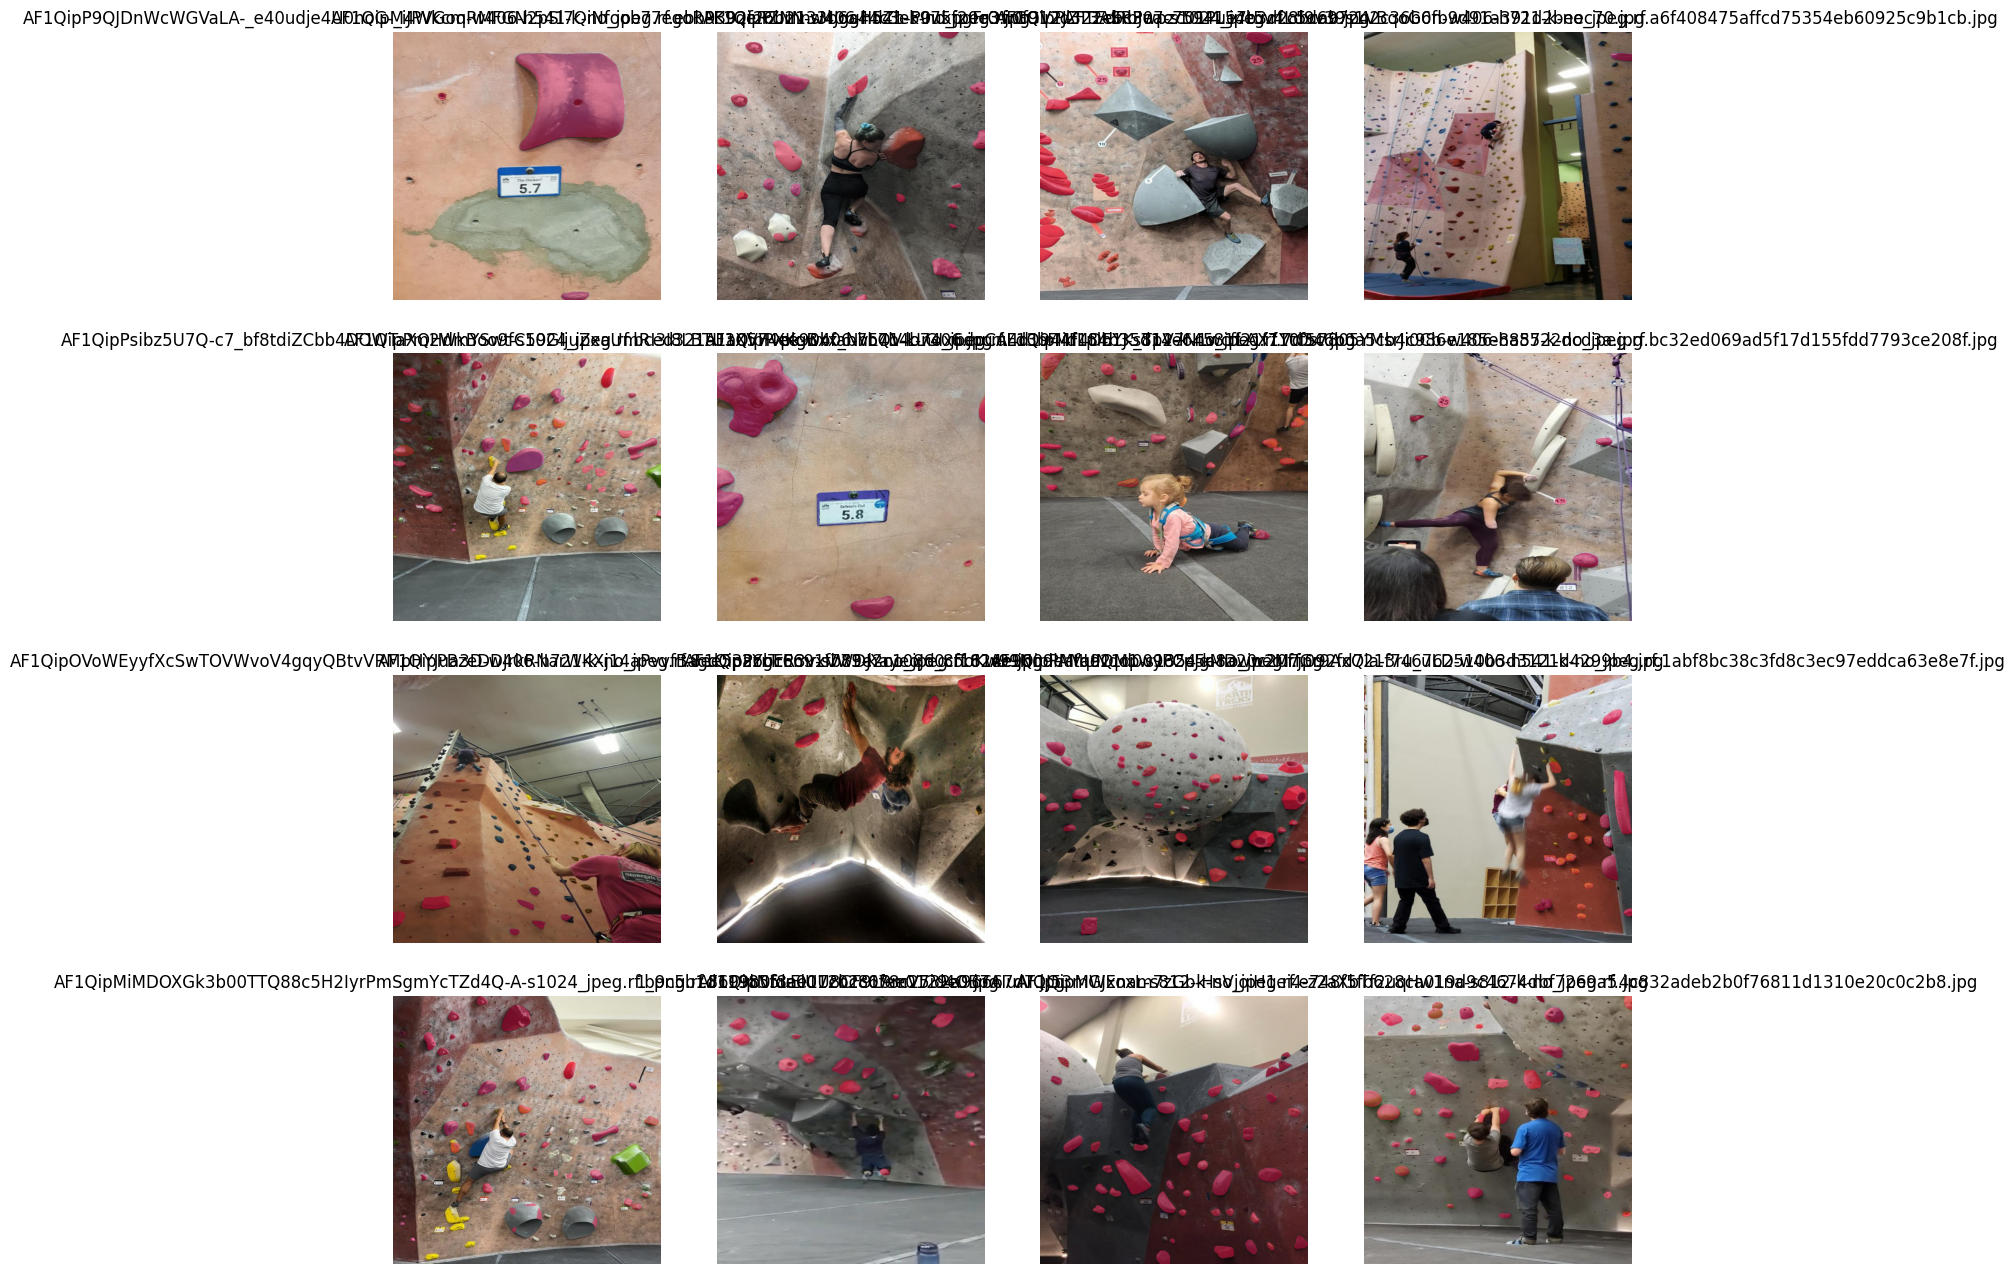

In [ ]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

import cv2
import supervision as sv
from random import sample
from tqdm import tqdm

all_imgs = list(pred_dataset.images.keys())
all_imgs = [img for img in all_imgs if img not in base_model.ontology.ref_dataset.images]

titles = [
    image_path
    for image_path
    in sample(all_imgs,SAMPLE_SIZE)]

ann_images = [
    annotator.annotate(scene=pred_dataset.images[title],detections=pred_dataset.annotations[title]) for title in titles
]

sv.plot_images_grid(images=ann_images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [ ]:
from autodistill_seggpt.find_best_examples import imgset_entries
len(imgset_entries)
demo_dataset = imgset_entries[0][1]

from autodistill_seggpt.dataset_utils import extract_classes_from_dataset
gt_demo_dataset = extract_classes_from_dataset(valid_dataset,[1])

show_img(demo_dataset,0)

from autodistill_seggpt.metrics import iou
iou(gt_demo_dataset, demo_dataset)

ModuleNotFoundError: No module named 'autodistill_seggpt.find_best_examples'

In [ ]:

from autodistill_seggpt import SegGPT,FewShotOntology

for i in range(1):
    climbing_ontology = FewShotOntology(train_dataset)

    base_model = SegGPT(
        ontology=climbing_ontology
    )

    pred_dataset = label_dataset(valid_dataset, base_model, use_tqdm=True)
    pred_datasets.append(pred_dataset)

Finding best examples for class 1-climbing-holds.


Best/Last IoU: 0.37/0.37: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


Finding best examples for class 2-floor.


Best/Last IoU: 0.4/0.4: 100%|██████████| 10/10 [01:14<00:00,  7.47s/it]


Finding best examples for class 3-person.


100%|██████████| 8/8 [00:39<00:00,  4.90s/it]


: 

In [ ]:
from autodistill_seggpt.metrics import iou
from autodistill_seggpt.dataset_utils import extract_classes_from_dataset
gt_dataset = extract_classes_from_dataset(valid_dataset, range(1,len(valid_dataset.classes)))
print(iou(gt_dataset, pred_dataset))

0.673961214211431


In [ ]:
def show_side_by_side(img_name:str):
    # show detections for this image from all pred_datasets.
    # put them side-by-side in one PIL Image.

    num_datasets = len(pred_datasets)

    img = valid_dataset.images[img_name]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotator = sv.MaskAnnotator()

    # make new img with dimensions of img, but with num_datasets times the width
    ret_img = Image.new(
        "RGB", (img.shape[1] * num_datasets, img.shape[0]), color=(255, 255, 255)
    )

    # paste each image into the new image
    for i,pred_dataset in enumerate(pred_datasets):
        detections = pred_dataset.annotations[img_name]
        tmp_img = annotator.annotate(scene=img,detections=detections)
        tmp_img = Image.fromarray(tmp_img)
        # paste tmp_img into ret_img
        x_offset = i * img.shape[1]
        ret_img.paste(tmp_img, (0, x_offset))
    return ret_img

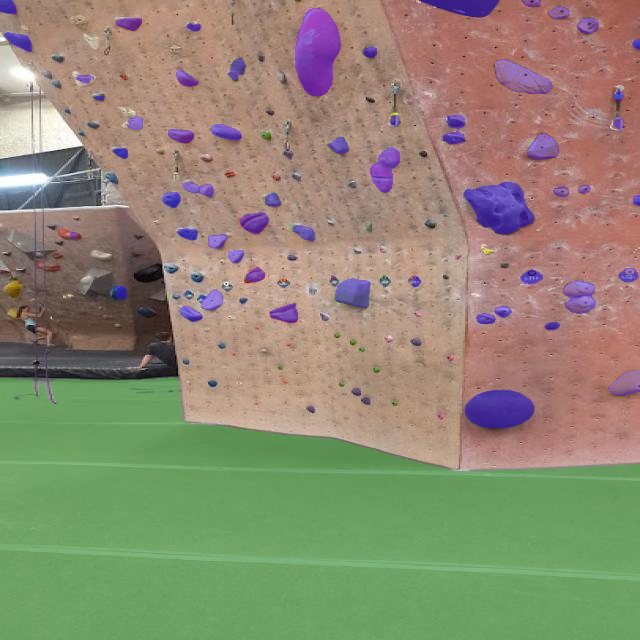

In [ ]:
name = choice(list(valid_dataset.images.keys()))

show_side_by_side(name)